# TensorFlow Lite Tutorial


## Overview: Using SensiML with TensorFlow Lite for Microcontrollers

In this tutorial, we are going to build a Boxing Gesture Recognition application that can run entirely on a Cortex-M4 microcontroller using [SensiML Analytics Toolkit](https://sensiml.com/)  and [TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers). The model we create will use the onboard IMU sensor as input, SensiML Knowledge Pack for feature extraction, and TensorFlow Lite for Microcontrollers to perform Classification.

## Objectives
 
1.   Build a data pipeline to extract features in real-time on your target device.
2.   Train a neural network using TensorFlow to classify the extracted features.
3.   Quantize the trained neural network and load it into the SensiML pipeline.
4.   Compile the pipeline into a Knowledge Pack Firmware.
 

## Creating a Model to Classify Gestures
 
We will use Google Colab to train a neural network with TensorFlow. You can also use your local environment if you have TensorFlow installed. [Click here](https://colab.research.google.com/drive/1i-Gk7ZXXLw-xflVGsQG2d4WiKFWwdd3C?usp=sharing) to get the notebook and try yourself.

 The video below will walk through training a TensorFlow model in Google Colab. 

In [ ]:
show_video("Kl005jjJSLk")

 
### SensiML Python SDK
 
We are going to connect to SensiML's cloud engine using the SensiML Python SDK. If you have not yet created an account on SensiML you will need to do that before continuing. You can create a free account by going [here](https://sensiml.com/plans/community-edition/)
 
To install the client in the Google Colab environment run the command in the following cell. 


In [ ]:
!pip install sensiml -U

Next, import the SensiML Python SDK and use it to connect to SensiML Cloud.  Run the following cell, which will ask you for your username and password. After connecting, you will be able to use the SensiML Python SDK to manage the data in your project, create queries, build and test models as well as download firmware. Further documentation for using the SensiML Python SDK can be found [here](https://sensiml.com/documentation/sensiml-python-sdk/overview.html).

In [ ]:
from sensiml import SensiML
client = SensiML()

*Next* we are going to connect to our **Boxing Glove Gestures Demo** Project. Run the following cell to connect to the project. If you haven't uploaded the project to your account you can get it [here](https://sensiml.com/datadepot/datasets/heavy-bag-punching/).



In [ ]:
client.project = 'Boxing Glove Gestures Demo'

### Creating a pipeline 
 
Pipelines are a key component of the SensiML workflow. Pipelines store the preprocessing, feature extraction, and model building steps. When training a model, these steps are executed on the SensiML server. Once the model has been trained, the pipeline is converted to a firmware code that will run on your target embedded device. For more documentation on pipelines see the advanced model building [tutorial](https://sensiml.com/documentation/sensiml-python-sdk/getting-started-with-the-sensiml-python-sdk.html). To create a new empty pipeline, run the cell below.

In [ ]:
client.pipeline = 'TensorFlow Lite Micro'

Sandbox TensorFlow Lite Micro does not exist, creating a new sandbox.


Now we are going to add our preprocessing steps to the pipeline, for a detailed description of the features available in a pipeline see the documentation [here](https://sensiml.com/documentation/pipeline-functions/overview.html). 

You can also list the functions by running ```client.list_functions(qgrid=False)``` in a code cell of the notebook.

### Adding steps to the pipeline

The pipeline for this tutorial will consist of the following steps:
 
1.   The **Input Query** which specifies what data is being fed into the model
2.   The **Feature Generators** which specify which features should be extracted from the raw time-series data
3.   The **Feature Transform** which specifies how to transform the features after extraction. In this case, it is to scale them to 1 byte each
4.   The **Feature Selector** which selects the best features. In this case, we are using the custom feature selector to downsample the data. 
 
 
The code in the following cell sets our initial variables, then specifies each step in the pipeline. For now, you don't need to dig into each of these steps, but just know that the end result will be a feature vector scaled to 1-byte values for each of the segments that were labeled in the Data Studio. We will use these features as input to our TensorFlow model.

In [ ]:
sensor_columns= list(client.project.columns())+["Magnitude_ST_0000"]

client.pipeline.reset()
client.pipeline.set_input_query("GesturePunches") # specify the input data set to use
client.pipeline.add_feature_generator(            # Add Feature Generators
    [
        {'subtype_call': 'Statistical'},
        {'subtype_call': 'Shape'},
        {'subtype_call': 'Column Fusion'},
        {'subtype_call': 'Area'},
        {'subtype_call': 'Rate of Change'},
    ],
    function_defaults={'columns': sensor_columns},
)

client.pipeline.add_feature_selector([{'name':'Tree-based Selection', 'params':{"number_of_features":16}},])

client.pipeline.add_transform("Min Max Scale")     # Scale the features to 1-byte

client.pipeline.describe()

### Generating feature vectors
 
At this point the pipeline has not been executed yet, we are just assembling the steps. To run the pipeline, execute the following cell. This will execute the pipeline on SensiML Cloud and return the results as a pandas DataFrame. 
 
Once the pipeline is finished running, the results will be stored in the variable *fv_t*. A summary of the execution is stored in the *s_t* variable. 

In [ ]:
fv_t, s_t = client.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: GesturePunches            		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: selector_set              		Type: selectorset              
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: M

In [ ]:
fv_t.head()

,gen_0005_AccelerometerYMean,gen_0006_AccelerometerZMean,gen_0039_AccelerometerXLinearRegressionStdErr_0003,gen_0046_AccelerometerXStd,gen_0067_AccelerometerXIQR,gen_0074_AccelerometerX25Percentile,gen_0082_AccelerometerY75Percentile,gen_0083_AccelerometerZ75Percentile,gen_0096_AccelerometerYminimum,gen_0110_AccelerometerYSum,gen_0130_AccelerometerXVariance,gen_0285_AXAY_cross_min_max_diff,gen_0306_AXAY_cross_mean_diff,gen_0309_AYAZ_cross_mean_diff,gen_0337_AccelerometerYTotArea,gen_0358_AccelerometerYAbsAreaDc,Punch,SegmentID,Type,segment_uuid
0,84,148,171,168,21,245,75,136,0,84,118,102,197,66,84,33,Cross,60,Train,6d5c5130-97f1-457b-8d9c-8ba2184fca2a
1,90,149,184,181,72,204,78,157,0,90,135,102,190,69,90,32,Cross,61,Train,e5de78f0-3ec1-40f1-bfaf-a5500c8dc86c
2,101,151,162,160,93,181,93,151,0,101,108,102,183,74,101,31,Cross,62,Train,e45bd9d8-f65f-41ff-8194-45b19eb9438e
3,88,166,148,145,81,191,79,169,0,88,90,254,197,55,88,27,Cross,63,Train,1011ddf4-96fb-451f-b855-07d11da46572
4,80,174,152,149,71,195,85,169,0,80,95,254,200,44,80,49,Cross,64,Train,5c39ff84-75df-4508-ac64-99a198ea7e4d


Run the following cell to see the distribution of feature each across the different classes. The best features will have low variance and good class separation.

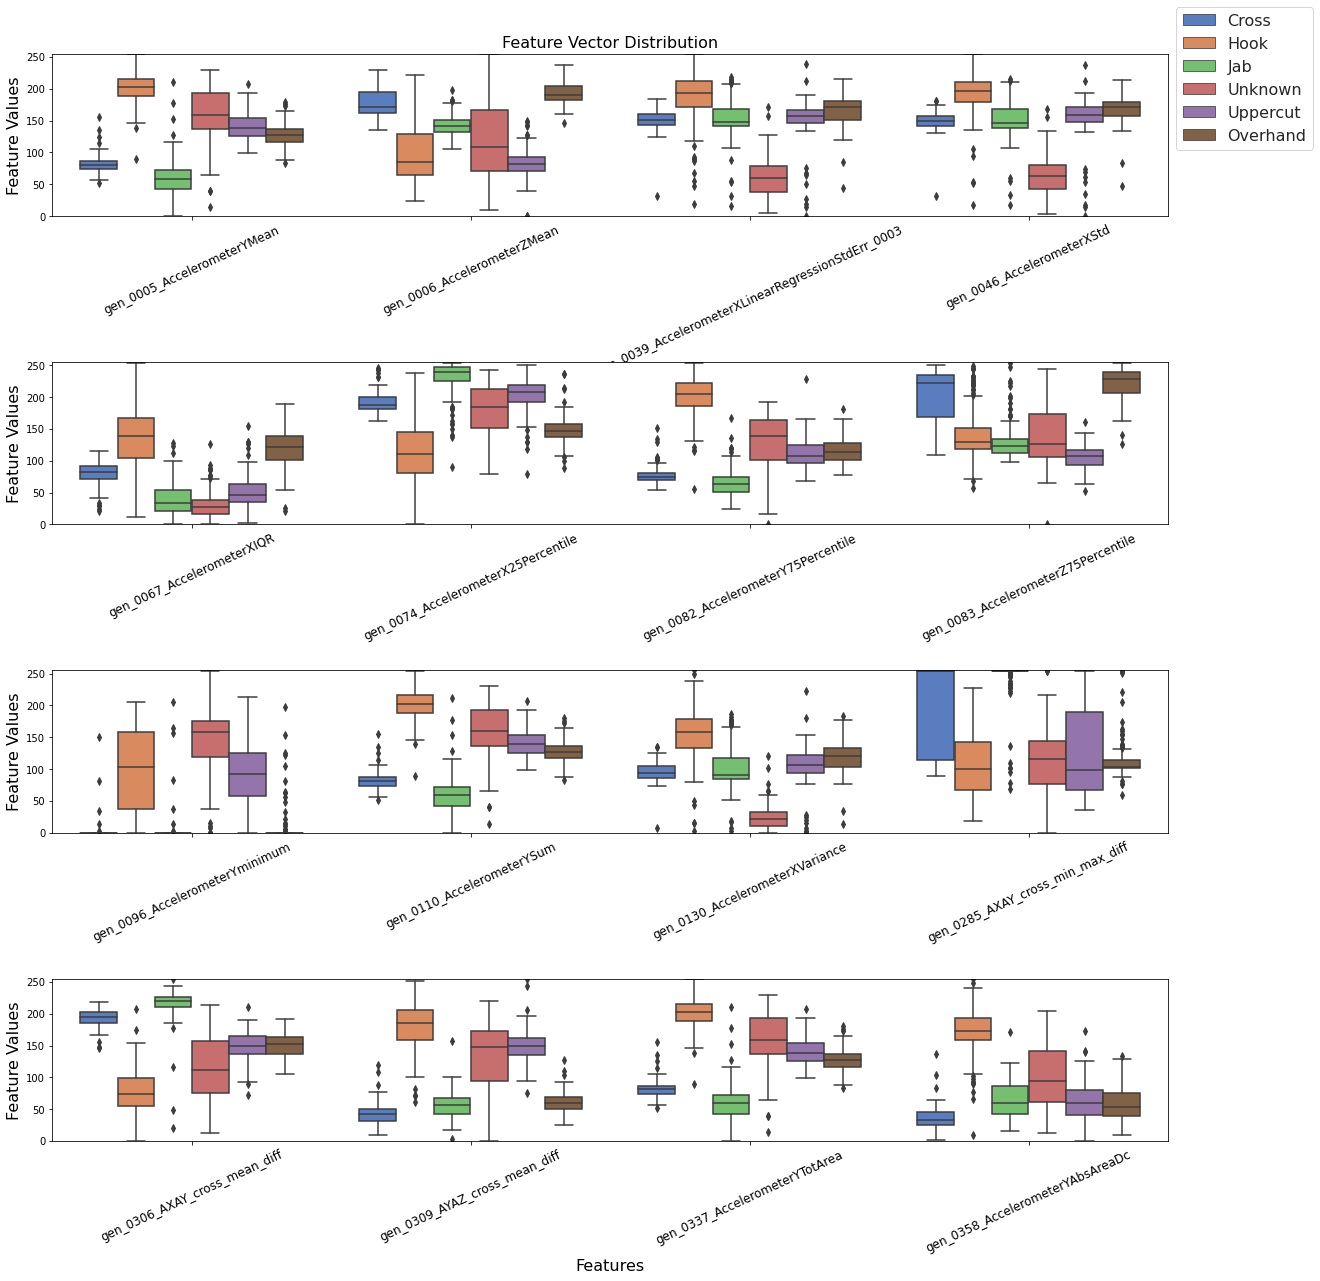

In [ ]:
client.pipeline.visualize_features(fv_t)

Now we have our features for this model, we will go ahead and train a TensorFlow Model in the colab environment. We will start by splitting our dataset into train and validate groups. Our test set is not included in the query and will be used later. 
 
The SensiML Python SDK has a built-in function for performing this split. You can also pass in the validation data test sizes. By default, they are set to 10% each.

In [ ]:
x_train, x_test, x_validate, y_train, y_test, y_validate, class_map = \
    client.pipeline.features_to_tensor(fv_t, test=0.0, validate=.1)

-----  Summary  -----
Class Map: {'Cross': 0, 'Hook': 1, 'Jab': 2, 'Unknown': 3, 'Uppercut': 4, 'Overhand': 5}
Train:
 total:  645
 by class: [ 92. 120. 130.  91. 108. 104.]
Validate:
 total:  72
 by class: [ 8. 15. 11. 19. 11.  8.]
Train:
 total:  0
 by class: [0. 0. 0. 0. 0. 0.]


### Creating a TensorFlow model
 
The Next step is to define what our TensorFlow model looks like. For this tutorial, we are going to use the TensorFlow Keras API to create the NN. When you are building a model to deploy on a microcontroller, it is important to remember that all functions of TensorFlow are not suitable for a microcontroller. Additionally, only a subset of TensorFlow functions is available as part of TensorFlow Lite Micro. For a full list of available functions see the [all_ops_resolver.cc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/all_ops_resolver.cc). 
 
For this tutorial, we will create a deep fully connected network to efficiently classify the boxing gestures. Our aim is to limit the number and size of every layer in the model to only those necessary to get our desired accuracy. Often you will find that you need to make a trade-off between latency/memory usage and accuracy in order to get a model that will work well on your microcontroller.

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

tf_model = tf.keras.Sequential()

tf_model.add(layers.Dense(12, activation='relu',kernel_regularizer='l1', input_shape=(x_train.shape[1],)))
tf_model.add(layers.Dropout(0.1))
tf_model.add(layers.Dense(8, activation='relu', input_shape=(x_train.shape[1],)))
tf_model.add(layers.Dropout(0.1))
tf_model.add(layers.Dense(y_train.shape[1], activation='softmax'))

# Compile the model using a standard optimizer and loss function for regression
tf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf_model.summary()
train_history = {'loss':[], 'val_loss':[], 'accuracy':[], 'val_accuracy':[]}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                204       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 54        
Total params: 362
Trainable params: 362
Non-trainable params: 0
_________________________________________________________________


### Training the TensorFlow model
 
After defining the model graph, it is time to train the model. Training NN consists of iterating through batches of your training dataset multiple times, each time it loops through the entire training set is called an epoch. For each batch of data, the loss function is computed and the weights of the layers in the network are adjusted.  
 
The following cell will loop through the training data num_iterations of times. Each time running a specific number of epochs. After each iteration, the visualizations for the loss, accuracy, and confusion matrix will be updated for both the validation and training data sets. You can use this to see how the model is progressing. 

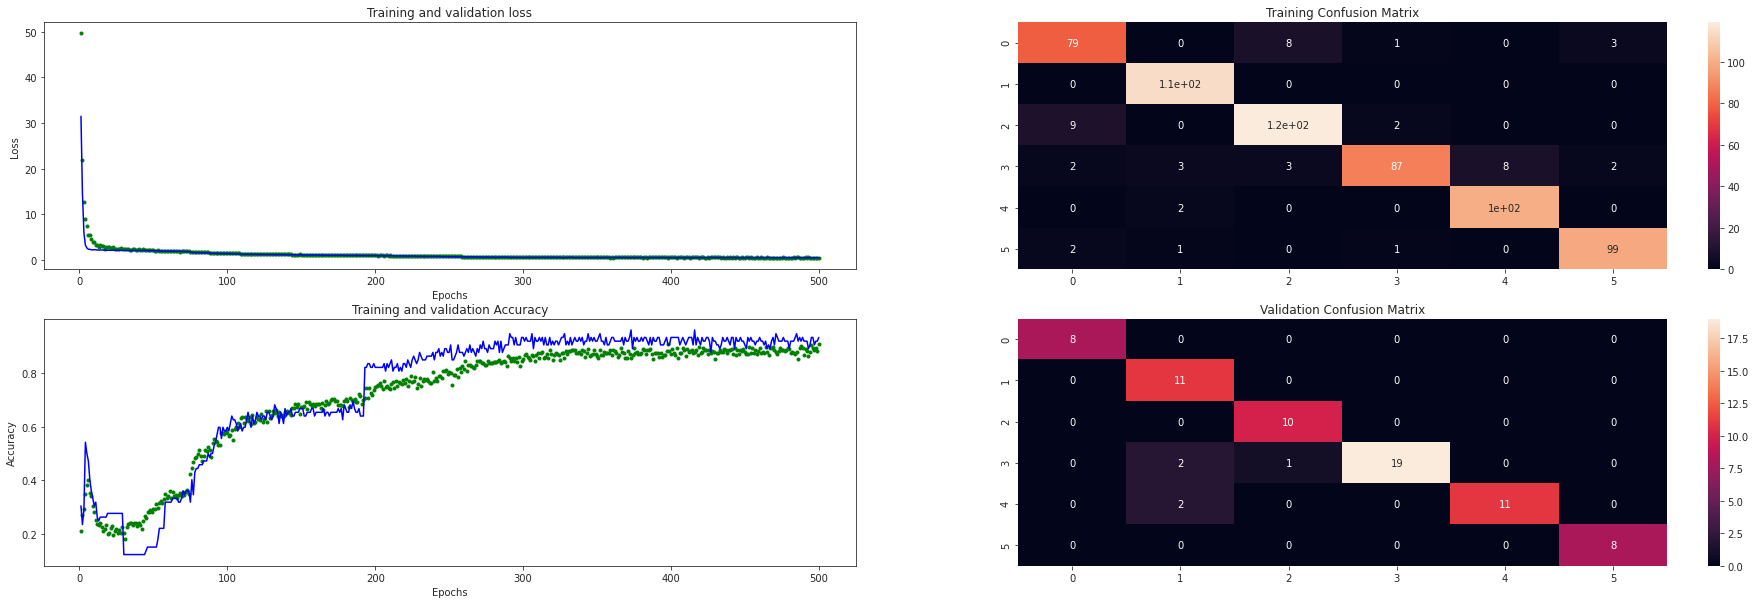

In [ ]:
from IPython.display import clear_output
import sensiml.tensorflow.utils as sml_tf

num_iterations=1
epochs=100
batch_size=32


data  = tf.data.Dataset.from_tensor_slices((x_train, y_train))
shuffle_ds = data.shuffle(buffer_size=x_train.shape[0], reshuffle_each_iteration=True).batch(batch_size)

for i in range(num_iterations):
    history = tf_model.fit( shuffle_ds, epochs=epochs, batch_size=batch_size, validation_data=(x_validate, y_validate), verbose=0)

    for key in train_history:
        train_history[key].extend(history.history[key])

    clear_output()    
    sml_tf.plot_training_results(tf_model, train_history, x_train, y_train, x_validate, y_validate)


### Quantize the TensorFlow model
 
Now that you have trained a neural network with TensorFlow, we are going to use the built-in tools to quantize it. Quantization of NN allows use to reduce the model size by up to 4x by converting the network weights from 4-byte floating-point values to 1-byte uint8. This can be done without sacrificing much in terms of accuracy. The best way to perform quantization is still an active area of research. For this tutorial, we will use the built-in methods that are provided as part of TensorFlow. 
 
*   The ```representative_dataset_generator()``` function is necessary to provide statistical information about your dataset in order to quantize the model weights appropriately. 
*   The TFLiteConverter is used to convert a TensorFlow model into a tensor flow lite model. The TensorFlow lite model is stored as a [flatbuffer](https://google.github.io/flatbuffers/) which allows us to easily store and access it on embedded systems.

In [ ]:
import numpy as np
def representative_dataset_generator():
    for value in x_validate:
    # Each scalar value must be inside of a 2D array that is wrapped in a list
        yield [np.array(value, dtype=np.float32, ndmin=2)]

In [ ]:
# Unquantized Model
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
tflite_model_full = converter.convert()
print("Full Model Size", len(tflite_model_full))

# Quantized Model
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.representative_dataset = representative_dataset_generator
tflite_model_quant = converter.convert()

print("Quantized Model Size", len(tflite_model_quant))

INFO:tensorflow:Assets written to: /tmp/tmplq8x91qn/assets


INFO:tensorflow:Assets written to: /tmp/tmplq8x91qn/assets


Full Model Size 3128
INFO:tensorflow:Assets written to: /tmp/tmpd_z6dko0/assets


INFO:tensorflow:Assets written to: /tmp/tmpd_z6dko0/assets


Quantized Model Size 3088


An additional benefit of quantizing the model is that TensorFlow Lite Micro is able to take advantage of specialized instructions on Cortex-M processors using the [cmsis-nn](http://www.keil.com/pack/doc/cmsis/NN/html/index.html) DSP library which gives another huge boost in performance. For more information on TensorFlow lite for microcontrollers, you can check out the excellent [tinyml](https://www.oreilly.com/library/view/tinyml/9781492052036/) book by Pete Warden.

### Uploading the TensorFlow Lite model to SensiML Cloud 

Now that you have trained your model, it's time to upload it as the final step in your pipeline. From here you will be able to test the entire pipeline against test data as well as download the firmware which can be flashed to run locally on your embedded device. To do this we will use the **Load Model TF Micro** function. We will convert the tflite model and upload it to the SensiML Cloud server. 
 
*Note: An additional parameter that can be specified here is the threshold. We set it to .1 in these examples. Any classification with a value less than the threshold will be returned as the **unknown** classification.*

In [ ]:
class_map_tmp = {k:v+1 for k,v in class_map.items()} #increment by 1 as 0 corresponds to unknown

client.pipeline.set_training_algorithm("Load Model TF Micro",
                                    params={"model_parameters": {
                                            'tflite': sml_tf.convert_tf_lite(tflite_model_quant)},
                                            "class_map": class_map_tmp,
                                            "estimator_type": "classification",
                                            "threshold": 0.0,
                                            "train_history":train_history,
                                            "model_json": tf_model.to_json()
                                            })

client.pipeline.set_validation_method("Recall", params={})

client.pipeline.set_classifier("TF Micro", params={})

client.pipeline.set_tvo()

results, stats = client.pipeline.execute()

### Model summary
After executing the pipeline, the cloud computes a model summary as well as a confusion matrix. The model summary gives a quick overview of the model performance so we can see what the accuracy of the quantized model was across our data set.
 



In [ ]:
results.summarize()

TRAINING ALGORITHM: Load Model TF Micro
VALIDATION METHOD:  Recall
CLASSIFIER:         TF Micro

AVERAGE METRICS:
                 F1_SCORE:  92.6  std: 0.00
                PRECISION:  92.8  std: 0.00
              SENSITIVITY:  92.7  std: 0.00

--------------------------------------

RECALL MODEL RESULTS : SET VALIDATION

MODEL INDEX: Fold 0
                 F1_SCORE:    train: 92.64  validation: 92.64  
              SENSITIVITY:    train: 92.71  validation: 92.71  



### Confusion matrix
 
The confusion matrix provides information not only about the accuracy but also what sort of misclassifications occurred. The confusion matrix is often one of the best ways to understand how your model is performing, as you can see which classes are difficult to distinguish between.
 
 The confusion matrix here also includes the Sensitivity and Positive Predictivity for each class along with the overall accuracy. If you raise the threshold value, you will notice that some of the classes start showing up as having UNK values. This corresponds to an unknown class and is useful for filtering out False Positives or detecting anomalous states.

In [ ]:
model = results.configurations[0].models[0]
model.confusion_matrix_stats['validation']

CONFUSION MATRIX:
               Cross      Hook       Jab   Unknown  Uppercut  Overhand       UNK       UNC   Support   Sens(%)
     Cross      87.0       0.0      10.0       2.0       0.0       1.0       0.0       0.0     100.0      87.0
      Hook       0.0     125.0       0.0       6.0       3.0       1.0       0.0       0.0     135.0      92.6
       Jab       8.0       0.0     129.0       4.0       0.0       0.0       0.0       0.0     141.0      91.5
   Unknown       1.0       0.0       2.0     106.0       0.0       1.0       0.0       0.0     110.0      96.4
  Uppercut       0.0       0.0       0.0       8.0     111.0       0.0       0.0       0.0     119.0      93.3
  Overhand       3.0       0.0       0.0       2.0       0.0     107.0       0.0       0.0     112.0      95.5

     Total        99       125       141       128       114       110         0         0       717          

PosPred(%)      87.9     100.0      91.5      82.8      97.4      97.3                      

 
*Finally*, we save the model knowledge pack with a name. This tells the server to persist the model. Models that you persist can be retrieved and viewed in the Analytics Studio in the future. Models that are not saved will be deleted when the pipeline is rerun. 

In [ ]:
model.knowledgepack.save("TFu_With_SensiML_Features")

Knowledgepack 'TFu_With_SensiML_Features' updated.


### Testing a Model in the Analytics Studio
 
After saving your model, you can return back to the  [Analytics Studio](https://app.sensiml.cloud) to continue validating and generating your firmware. To test your model against any of the captured data files, 
, select the pipeline and 
 
1.   Go to the Explore Model tab of the Analytics Studio.
2.   Select the pipeline you built the model with.
3.   Select the model you want to test.
4.   Select any of the capture files in the Project.
5.   Click RUN to classify that capture using the selected model.
 
The model will be compiled in the SensiML Cloud and the output of the classification will be returned. The graph shows the segment start and segment classified for all of the detected events.

In [ ]:
show_video("5wkUriTDNUM")

## Live Model Validation

### Downloading the Knowledge Pack
 
Now that we have validated our model it's time for a live test. To build the firmware for your specific device go to the Download Model tab of the Analytics Studio. We support compiled binaries for our target platforms which include fully configured sensors and classification reporting over BLE. We also provide compiled libraries that can be integrated into your application. For enterprise customers, you will have full access to the SDK and can take the compiled models and modify or optimize them for your target devices. 
 
 
If you are using Community Edition you can download the firmware binary for your device. SensiML customers are able to download library and source code as well. Head over to the [Analytics Studio](https://app.sensiml.cloud) to download your model and flash it to the device.
To download the firmware for this tutorial 
 
1.   Go to the **Download Model** tab of the Analytics Studio
2.   Select the pipeline and model you want to download
3.   Select the HW platform
4.   Select Format **Library**
5.   To turn on debug output check Advanced Settings and set **Debug** to True
6.   Click on Output and add **Serial** as an option as well which enables uart output over serial
7.   Click Download and the model will be compiled and downloaded to your computer ready to flash.
 
After downloading the Knowledge Pack, follow the instructions associated with your firmware for flashing it. We have flashing instructions for our supported boards [here](https://sensiml.com/documentation/knowledge-packs/flashing-a-knowledge-pack-to-an-embedded-device.html). 
 



In [ ]:
show_video("XmRTPfcJAyY")

## Summary
 
We hope you enjoyed this tutorial using TensorFlow along with SensiML Analytics Toolkit. In this tutorial we have covered how to:
 
 
1.   Collect and annotate a high-quality data set
2.   Build a feature extraction pipeline using SensiML
3.   Use TensorFlow to train a NN to recognize different gestures
5.   Upload the TensorFlow Lite model to SensiML Cloud and download the Knowledge Pack firmware.
 
For more information about SensiML visit our website. To work with us to enable you to build your application get in [touch with us](https://sensiml.com/contact/)

 
### [SensiML](https://sensiml.com)
SensiML enables developers to quickly and easily create machine learning models that run locally on resource-constrained edge devices. SensiML SaaS provides an end to end solution from collecting and annotating a high-quality sensor time-series data set, to analyzing and building data models using AutoML, and finally generating firmware that will run on your target device.
 
 



### [TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers)
 
TensorFlow Lite for Microcontrollers is a port of TensorFlow Lite designed to run machine learning models on microcontrollers and other devices with only kilobytes of memory. It implements a limited subset of TensorFlow operations but is more than enough to build high accuracy models for running efficient inference on resource-constrained devices.